<a href="https://colab.research.google.com/github/tayyab-ilyas/call_analyser/blob/main/sales_call_analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import os
import re
import json
import warnings
import time
from datetime import timedelta
from typing import Dict, List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display, HTML

from pydub import AudioSegment
from pydub.silence import split_on_silence
import speech_recognition as sr

from transformers import pipeline

import subprocess

warnings.filterwarnings('ignore')


In [132]:
print("Loading AI models...")
whisper_model = whisper.load_model("base.en")

nlp = spacy.load("en_core_web_sm")

summarizer = pipeline("summarization", model="t5-small", device=-1)
print("AI models loaded successfully.")


Loading AI models...


Device set to use cpu


AI models loaded successfully.


In [133]:
class AudioDownloader:
    @staticmethod
    def download_from_youtube(url: str, output_path: str = "call_audio.wav") -> str:
        print(f"Downloading from: {url}")
        base_name = output_path.replace('.wav', '')
        video_file = f"{base_name}_video.mp4"
        commands = [
            ['yt-dlp', '-f', 'best[filesize<50M]/best', '-o', video_file, url],
            ['yt-dlp', '-f', 'mp4', '-o', video_file, url],
            ['yt-dlp', '-o', video_file, url]
        ]
        video_downloaded = False
        for i, command in enumerate(commands):
            try:
                print(f"Attempting video download method {i+1}...")
                result = subprocess.run(command, capture_output=True, text=True, timeout=120)
                if result.returncode == 0:
                    video_downloaded = True
                    break
                else:
                    print(f"Method {i+1} failed: {result.stderr[:200]}")
            except Exception as e:
                print(f"Method {i+1} error: {str(e)[:200]}")

        if video_downloaded:
            for ext in ['.mp4', '.webm', '.mkv', '.avi', '']:
                check_file = f"{base_name}_video{ext}"
                if os.path.exists(check_file):
                    video_file = check_file
                    break
            if os.path.exists(video_file):
                try:
                    print(f"Extracting audio from video: {video_file}")
                    video = AudioSegment.from_file(video_file)
                    audio = video.set_channels(1).set_frame_rate(16000)
                    audio.export(output_path, format="wav")
                    os.remove(video_file)
                    return output_path
                except Exception:
                    print("Trying direct ffmpeg extraction...")
                    ffmpeg_cmd = ['ffmpeg', '-i', video_file, '-vn', '-acodec', 'pcm_s16le', '-ar', '16000', '-ac', '1', '-y', output_path]
                    subprocess.run(ffmpeg_cmd, check=True, capture_output=True)
                    os.remove(video_file)
                    return output_path
        print("\n Download failed.")
        return None

    @staticmethod
    def preprocess_audio(audio_path: str) -> str:
        print("Preprocessing audio...")
        audio = AudioSegment.from_file(audio_path)
        audio = audio.set_channels(1).set_frame_rate(16000).normalize()
        processed_path = "processed_audio.wav"
        audio.export(processed_path, format="wav")
        return processed_path

In [134]:
class TranscriptionService:
    def __init__(self, model):
        self.model = model

    def transcribe_audio(self, audio_path: str) -> list[dict]:
        print(f"Starting full transcription of {audio_path} with Whisper...")
        result = self.model.transcribe(audio_path, word_timestamps=True, fp16=False)
        print("Transcription complete.")
        return result['segments']

class SpeakerDiarizer:
    def diarize_and_align(self, full_transcript: list[dict], audio_path: str) -> list[dict]:
        print("Diarizing speakers and aligning with transcript...")
        audio = AudioSegment.from_wav(audio_path)
        processed_transcript = []

        rms_values = [audio[seg['start']*1000:seg['end']*1000].rms for seg in full_transcript if len(audio[seg['start']*1000:seg['end']*1000]) > 0]
        if not rms_values: return full_transcript

        median_rms = np.median(rms_values)

        for segment in full_transcript:
            start_ms, end_ms = segment['start'] * 1000, segment['end'] * 1000
            audio_chunk = audio[start_ms:end_ms]
            speaker = 'Sales Rep' if len(audio_chunk) > 0 and audio_chunk.rms > median_rms else 'Customer'
            full_text = "".join([word_data['word'] for word_data in segment['words']]).strip()

            processed_transcript.append({
                'start': segment['start'],
                'end': segment['end'],
                'duration': segment['end'] - segment['start'],
                'text': full_text,
                'speaker': speaker,
                'words': segment['words']
            })

        print(f"Diarization complete.")
        return processed_transcript


In [135]:
class CallAnalyzer:
    def __init__(self):
        self.sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=-1)

    def calculate_talk_time_ratio(self, segments: list[dict]) -> dict[str, float]:
        talk_time = {'Sales Rep': 0, 'Customer': 0, 'Unknown': 0}
        for seg in segments:
            talk_time.setdefault(seg['speaker'], 0)
            talk_time[seg['speaker']] += seg['duration']
        total_time = sum(talk_time.values())
        return {k: (v / total_time) * 100 for k, v in talk_time.items()} if total_time > 0 else {}

    def calculate_speech_pace(self, segments: list[dict]) -> dict[str, float]:
        pace = {'Sales Rep': {'words': 0, 'time': 0}, 'Customer': {'words': 0, 'time': 0}}
        for seg in segments:
            speaker = seg.get('speaker', 'Unknown')
            if speaker in pace:
                pace[speaker]['words'] += len(seg['words'])
                pace[speaker]['time'] += seg['duration']
        return {s: (d['words'] / d['time']) * 60 if d['time'] > 0 else 0 for s, d in pace.items()}

    def analyze_sentiment_trend(self, segments: List[Dict]) -> Dict:
      sentiment_timeline = []
      for segment in segments:
          text = segment.get('text', '')
          if text and len(text) > 10:
              try:
                result = self.sentiment_analyzer(text[:512])[0]
                score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
                sentiment_timeline.append({
                    'time': (segment['start'] + segment['end']) / 2,
                    'score': score,
                    'speaker': segment['speaker']
                 })
              except:
                pass
      return {'timeline': sentiment_timeline}

    def analyze_interruptions(self, segments: list[dict]) -> dict[str, int]:
        interruptions = {'Sales Rep': 0, 'Customer': 0}
        for i in range(1, len(segments)):
            prev_seg = segments[i-1]
            curr_seg = segments[i]
            if curr_seg['speaker'] != prev_seg['speaker'] and curr_seg['start'] < prev_seg['end']:
                interrupting_speaker = curr_seg['speaker']
                if interrupting_speaker in interruptions:
                    interruptions[interrupting_speaker] += 1
        return interruptions

    def analyze_pauses(self, segments: list[dict]) -> dict:
        pauses = []
        for i in range(1, len(segments)):
            if segments[i]['speaker'] != segments[i-1]['speaker']:
                pause_duration = segments[i]['start'] - segments[i-1]['end']
                if pause_duration > 0.5:
                    pauses.append(pause_duration)
        if not pauses:
            return {'average_pause': 0, 'longest_pause': 0}
        return {'average_pause': np.mean(pauses), 'longest_pause': np.max(pauses)}

    def analyze_question_types(self, segments: list[dict]) -> dict:
        question_counts = {'Sales Rep': {'open': 0, 'closed': 0}, 'Customer': {'open': 0, 'closed': 0}}
        open_ended_starters = r'^(what|when|where|who|why|how|tell me|describe)\b'
        closed_ended_starters = r'^(is|are|was|were|do|does|did|will|would|can|could|should|have|has|had)\b'
        for seg in segments:
            text = seg['text'].lower().strip()
            speaker = seg.get('speaker', 'Unknown')
            if '?' in text and speaker in question_counts:
                if re.search(open_ended_starters, text):
                    question_counts[speaker]['open'] += 1
                elif re.search(closed_ended_starters, text):
                    question_counts[speaker]['closed'] += 1
        return question_counts

    def extract_entities(self, full_text: str) -> dict:
        doc = nlp(full_text)
        entities = {'PERSON': set(), 'ORG': set(), 'MONEY': set()}
        for ent in doc.ents:
            if ent.label_ in entities:
                entities[ent.label_].add(ent.text)
        # Convert sets to lists for JSON compatibility
        return {k: list(v) for k, v in entities.items()}

    def generate_abstractive_summary(self, full_text: str) -> str:
        max_length = min(len(full_text.split()), 512)
        truncated_text = " ".join(full_text.split()[:max_length])

        if len(truncated_text) < 50:
            return

        summary = summarizer(truncated_text, max_length=100, min_length=25, do_sample=False)
        return summary[0]['summary_text']


In [136]:
class CallQualityAnalyzer:
    def __init__(self):
        self.downloader = AudioDownloader()
        self.transcriber = TranscriptionService(whisper_model)
        self.diarizer = SpeakerDiarizer()
        self.analyzer = CallAnalyzer()

    def analyze_call(self, source: str, is_youtube: bool = True) -> dict:
        start_time = time.time()
        print("="*50 + "\n STARTING ADVANCED CALL ANALYSIS \n" + "="*50)

        audio_path = self.downloader.download_from_youtube(source) if is_youtube else source
        if not audio_path: return {"error": "Failed to get audio file."}

        processed_path = self.downloader.preprocess_audio(audio_path)

        full_transcript_segments = self.transcriber.transcribe_audio(processed_path)
        diarized_segments = self.diarizer.diarize_and_align(full_transcript_segments, processed_path)

        full_text = " ".join([seg['text'] for seg in diarized_segments])

        metrics = {
            'talk_time_ratio': self.analyzer.calculate_talk_time_ratio(diarized_segments),
            'speech_pace': self.analyzer.calculate_speech_pace(diarized_segments),
            'interruptions': self.analyzer.analyze_interruptions(diarized_segments),
            'pauses': self.analyzer.analyze_pauses(diarized_segments),
            'question_types': self.analyzer.analyze_question_types(diarized_segments),
            'sentiment_trend': self.analyzer.analyze_sentiment_trend(diarized_segments),
            'entities': self.analyzer.extract_entities(full_text),
            'summary': self.analyzer.generate_abstractive_summary(full_text)

        }

        metrics['processing_time'] = time.time() - start_time
        metrics['diarized_segments'] = diarized_segments
        metrics['audio_path'] = processed_path

        print("\n" + "="*50 + "\n ANALYSIS COMPLETE\n" + "="*50)
        return metrics

    def display_results(self, metrics: dict):
        if "error" in metrics:
            print(f" Error: {metrics['error']}")
            return

        print("\n KEY METRICS DASHBOARD\n" + "-" * 25)
        print(f" **AI-Generated Summary:**\n   {metrics['summary']}\n")

        print(" **Extracted Entities:**")
        for ent_type, ent_list in metrics['entities'].items():
            if ent_list:
                print(f"   - {ent_type}: {', '.join(ent_list)}")

        print("\n **Talk Time & Pace:**")
        print(f"   - Talk Ratio (Rep/Cust): {metrics['talk_time_ratio'].get('Sales Rep', 0):.0f}% / {metrics['talk_time_ratio'].get('Customer', 0):.0f}%")
        print(f"   - Pace (Rep/Cust WPM): {metrics['speech_pace'].get('Sales Rep', 0):.0f} / {metrics['speech_pace'].get('Customer', 0):.0f}")

        print("\n **Conversational Dynamics:**")
        print(f"   - Interruptions (Rep/Cust): {metrics['interruptions'].get('Sales Rep', 0)} / {metrics['interruptions'].get('Customer', 0)}")
        print(f"   - Longest Pause Between Turns: {metrics['pauses']['longest_pause']:.1f}s")

        print("\n **Question Analysis (Sales Rep):**")
        rep_questions = metrics['question_types']['Sales Rep']
        print(f"   - Open-Ended: {rep_questions['open']}")
        print(f"   - Closed-Ended: {rep_questions['closed']}")

        print(f"\n **Total Processing Time:** {metrics['processing_time']:.1f} seconds")


In [137]:
def visualize_analysis(metrics: Dict):
    if "error" in metrics:
        print("Cannot visualize due to error in analysis")
        return

    segments = metrics['diarized_segments']
    sentiment_timeline = metrics['sentiment_trend']['timeline']

    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 2)
    fig.suptitle('Advanced Sales Call Analysis Dashboard', fontsize=20, fontweight='bold')

    ax1 = fig.add_subplot(gs[0, :])
    colors = {'Sales Rep': 'royalblue', 'Customer': 'darkorange', 'Unknown': 'grey'}
    for seg in segments:
        ax1.barh(seg['speaker'], width=seg['end']-seg['start'], left=seg['start'], height=0.6,
                 color=colors.get(seg['speaker'], 'grey'), edgecolor='black')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_title('Conversation Timeline', fontsize=14)
    ax1.grid(axis='x', linestyle='--', alpha=0.6)
    handles = [mpatches.Patch(color=color, label=speaker) for speaker, color in colors.items()]
    ax1.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc='upper left')

    ax2 = fig.add_subplot(gs[1, 0])
    if sentiment_timeline:
        times = [s['time'] for s in sentiment_timeline]
        scores = [s['score'] for s in sentiment_timeline]
        ax2.plot(times, scores, marker='o', linestyle='-', color='purple', alpha=0.7)
        ax2.axhline(0, color='grey', linestyle='--')
        ax2.fill_between(times, scores, where=[s > 0 for s in scores], color='green', alpha=0.2, interpolate=True)
        ax2.fill_between(times, scores, where=[s < 0 for s in scores], color='red', alpha=0.2, interpolate=True)
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel('Sentiment Score (-1 to 1)')
        ax2.set_title('Sentiment Trend Over Time', fontsize=14)
        ax2.grid(True, linestyle=':', alpha=0.5)

    ax3 = fig.add_subplot(gs[1, 1])
    ratios = metrics['talk_time_ratio']
    ax3.pie(ratios.values(), labels=ratios.keys(), autopct='%1.1f%%', startangle=90, colors=['royalblue', 'darkorange', 'grey'])
    ax3.set_title('Talk Time Distribution', fontsize=14)

    ax4 = fig.add_subplot(gs[2, :])
    try:
        y, sr = librosa.load(metrics['audio_path'])
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax4)
        fig.colorbar(img, ax=ax4, format='%+2.0f dB', label='Intensity')
        ax4.set_title('Audio Spectrogram (Frequency Analysis)', fontsize=14)
    except Exception as e:
        ax4.text(0.5, 0.5, f"Could not generate spectrogram: {e}", ha='center', va='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Device set to use cpu


 STARTING ADVANCED CALL ANALYSIS 
Preprocessing audio...
Starting full transcription of processed_audio.wav with Whisper...
Transcription complete.
Diarizing speakers and aligning with transcript...
Diarization complete.


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



 ANALYSIS COMPLETE

 KEY METRICS DASHBOARD
-------------------------
 **AI-Generated Summary:**
   the price of the new map is $99 plus shipping and tax . it looks as though you haven't updated your vehicle for three years . I would definitely recommend taking advantage of the extra $50 off before it expires .

 **Extracted Entities:**
   - PERSON: John, Neeson, John Smith
   - MONEY: 99, 50

 **Talk Time & Pace:**
   - Talk Ratio (Rep/Cust): 46% / 54%
   - Pace (Rep/Cust WPM): 195 / 200

 **Conversational Dynamics:**
   - Interruptions (Rep/Cust): 0 / 0
   - Longest Pause Between Turns: 1.0s

 **Question Analysis (Sales Rep):**
   - Open-Ended: 0
   - Closed-Ended: 0

 **Total Processing Time:** 51.3 seconds


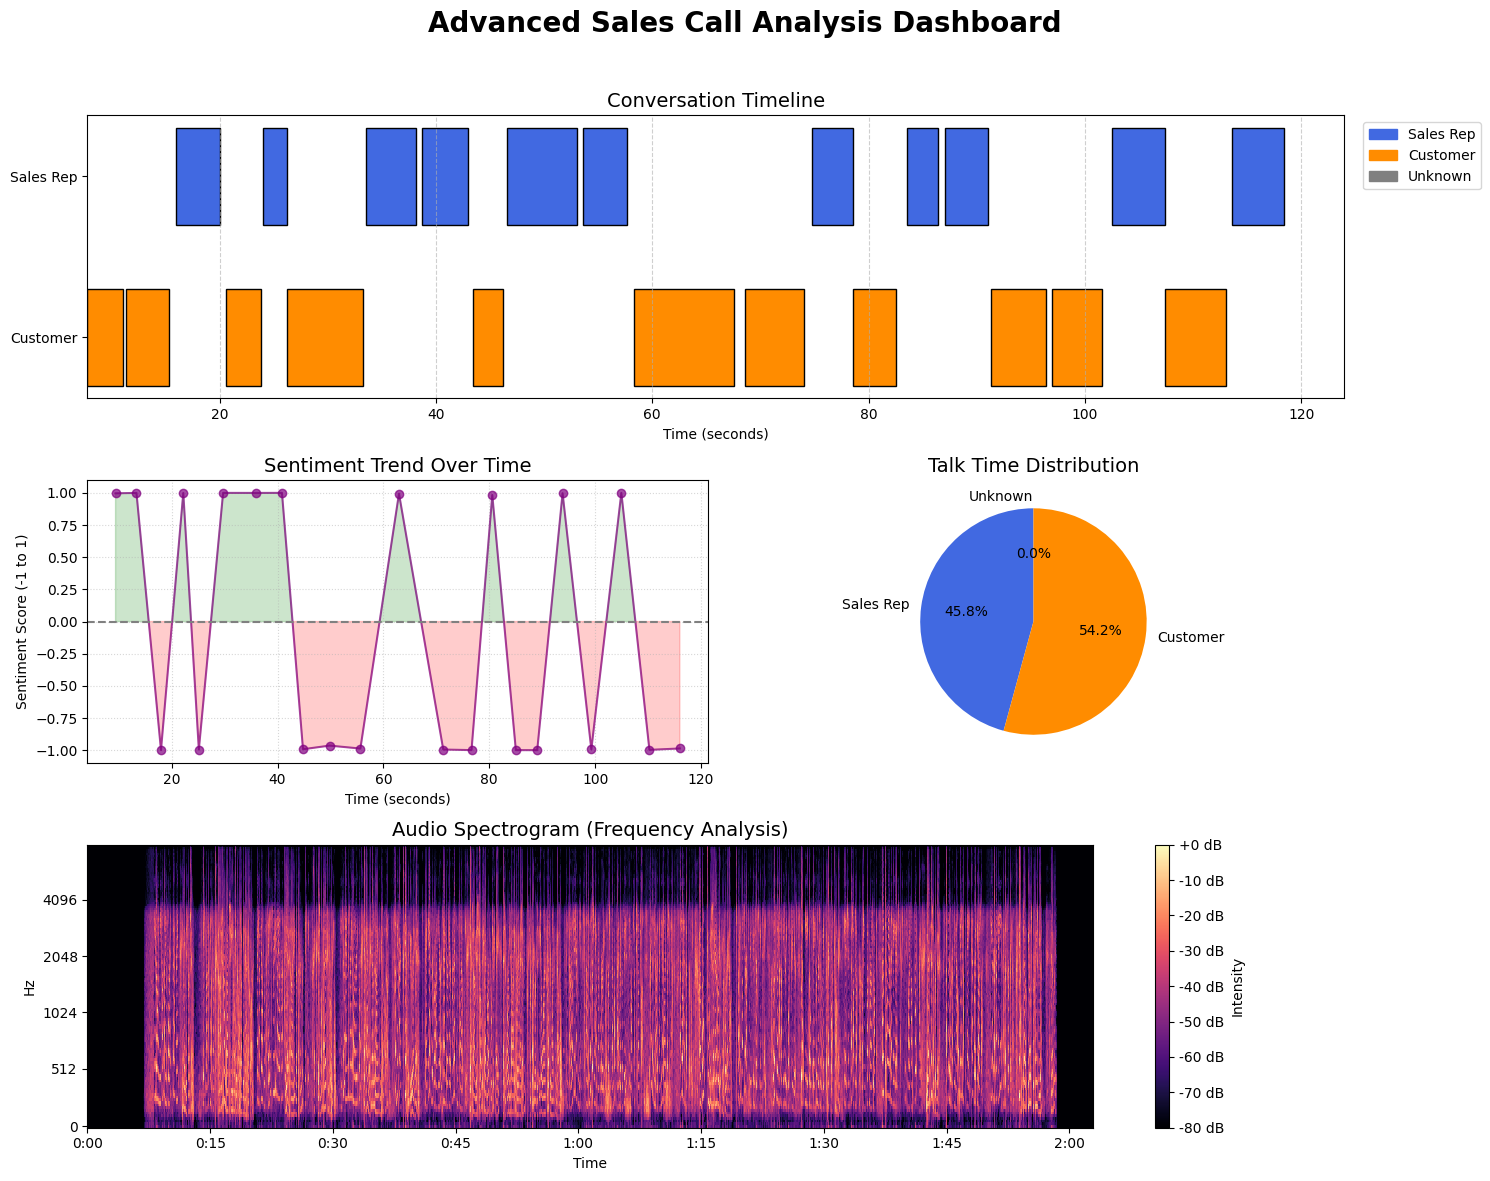

In [138]:
analyzer_pipeline = CallQualityAnalyzer()

audio_file_path = "Sales Call example 1 - Moduslinktube (youtube).mp3"

# Check if file exists before running
if os.path.exists(audio_file_path):
    results = analyzer_pipeline.analyze_call(audio_file_path, is_youtube=False)

    if results:
        analyzer_pipeline.display_results(results)
        visualize_analysis(results)
else:
    print(f" ERROR: Audio file not found at '{audio_file_path}'")
    print("Please upload your audio file and make sure the path is correct.")

